In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g5L2SByv4bAOAKEAsLbixcHD4EJAp8hLl7flx7fSwgqCvQSB91_0o0
Mounted at /content/drive


## Mounting Drive

Variable definitions

Client:

    Client_id: Unique id for client
    District: District where the client is
    Client_catg: Category client belongs to
    Region: Area where the client is
    Creation_date: Date client joined
    Target: fraud:1 , not fraud: 0

Invoice data

    Client_id: Unique id for the client
    Invoice_date: Date of the invoice
    Tarif_type: Type of tax
    Counter_number:
    Counter_statue: takes up to 5 values such as working fine, not working, on hold statue, ect
    Counter_code:
    Reading_remarque: notes that the STEG agent takes during his visit to the client (e.g: If the counter shows something wrong, the agent gives a bad score)
    Counter_coefficient: An additional coefficient to be added when standard consumption is exceeded
    Consommation_level_1: Consumption_level_1
    Consommation_level_2: Consumption_level_2
    Consommation_level_3: Consumption_level_3
    Consommation_level_4: Consumption_level_4
    Old_index: Old index
    New_index: New index
    Months_number: Month number
    Counter_type: Type of counter


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
import time

In [ ]:

invoice_train = pd.read_csv('/content/drive/My Drive/invoice_train.csv',low_memory=False)
client_train = pd.read_csv('/content/drive/My Drive/client_train (1).csv',low_memory=False)

In [ ]:
client_train.isnull().sum()

disrict          0
client_id        0
client_catg      0
region           0
creation_date    0
target           0
dtype: int64

In [ ]:
invoice_train.isnull().sum()

client_id               0
invoice_date            0
tarif_type              0
counter_number          0
counter_statue          0
counter_code            0
reading_remarque        0
counter_coefficient     0
consommation_level_1    0
consommation_level_2    0
consommation_level_3    0
consommation_level_4    0
old_index               0
new_index               0
months_number           0
counter_type            0
dtype: int64

## EDA

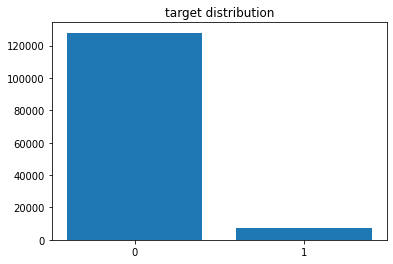

In [ ]:
ds = client_train.groupby(['target'])['client_id'].count()
plt.bar(x=ds.index, height=ds.values, tick_label =[0,1])
plt.title('target distribution')
plt.show()

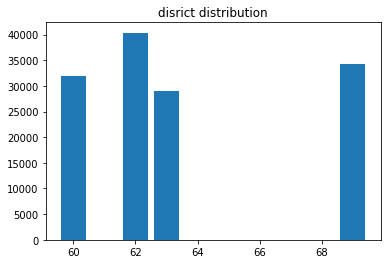

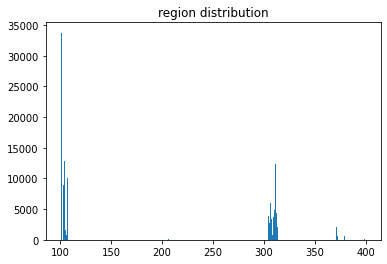

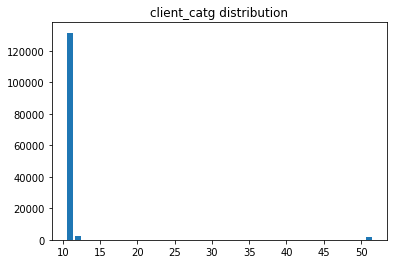

In [ ]:
for col in ['disrict','region','client_catg']:
    ds = client_train.groupby([col])['client_id'].count()
    plt.bar(x=ds.index, height=ds.values)
    plt.title(col+' distribution')
    plt.show()

In [ ]:
print('Number of unique values in invoice_train:')
for col in invoice_train.columns:
    print(f"{col} - {invoice_train[col].nunique()}")

Number of unique values in invoice_train:
client_id - 135493
invoice_date - 8275
tarif_type - 17
counter_number - 201893
counter_statue - 12
counter_code - 42
reading_remarque - 8
counter_coefficient - 16
consommation_level_1 - 8295
consommation_level_2 - 12576
consommation_level_3 - 2253
consommation_level_4 - 12075
old_index - 155648
new_index - 157980
months_number - 1370
counter_type - 2


In [ ]:
pd.options.display.max_rows = 999 
pd.options.display.max_columns=999

In [ ]:
client_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   disrict        135493 non-null  int64  
 1   client_id      135493 non-null  object 
 2   client_catg    135493 non-null  int64  
 3   region         135493 non-null  int64  
 4   creation_date  135493 non-null  object 
 5   target         135493 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 6.2+ MB


In [ ]:
invoice_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476749 entries, 0 to 4476748
Data columns (total 16 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   client_id             object
 1   invoice_date          object
 2   tarif_type            int64 
 3   counter_number        int64 
 4   counter_statue        object
 5   counter_code          int64 
 6   reading_remarque      int64 
 7   counter_coefficient   int64 
 8   consommation_level_1  int64 
 9   consommation_level_2  int64 
 10  consommation_level_3  int64 
 11  consommation_level_4  int64 
 12  old_index             int64 
 13  new_index             int64 
 14  months_number         int64 
 15  counter_type          object
dtypes: int64(12), object(4)
memory usage: 546.5+ MB


In [ ]:
def feature_change(cl, inv):

    cl['client_catg'] = cl['client_catg'].astype('category')
    cl['disrict'] = cl['disrict'].astype('category')
    cl['region'] = cl['region'].astype('category')
    cl['region_group'] = cl['region'].apply(lambda x: 100 if x<100 else 300 if x>300 else 200)
    cl['creation_date'] = pd.to_datetime(cl['creation_date'])
    
    cl['coop_time'] = (2019 - cl['creation_date'].dt.year)*12 - cl['creation_date'].dt.month

    inv['counter_type'] = inv['counter_type'].map({"ELEC":1,"GAZ":0})
    inv['counter_statue'] = inv['counter_statue'].map({0:0,1:1,2:2,3:3,4:4,5:5,769:5,'0':0,'1':1,'2':2,'3':3,'4':4,'5':5,'A':0})
    
    inv['invoice_date'] = pd.to_datetime(inv['invoice_date'], dayfirst=True)
    inv['invoice_month'] = inv['invoice_date'].dt.month
    inv['invoice_year'] = inv['invoice_date'].dt.year
    inv['is_weekday'] = ((pd.DatetimeIndex(inv.invoice_date).dayofweek) // 5 == 1).astype(float)
    inv['delta_index'] = inv['new_index'] - inv['old_index']
    
    return cl, inv



In [ ]:
client_train1, invoice_train1 = feature_change(client_train, invoice_train)

In [ ]:
client_train1.isnull().sum()

disrict          0
client_id        0
client_catg      0
region           0
creation_date    0
target           0
region_group     0
coop_time        0
dtype: int64

In [ ]:
invoice_train1.isnull().sum()

client_id                0
invoice_date             0
tarif_type               0
counter_number           0
counter_statue          34
counter_code             0
reading_remarque         0
counter_coefficient      0
consommation_level_1     0
consommation_level_2     0
consommation_level_3     0
consommation_level_4     0
old_index                0
new_index                0
months_number            0
counter_type             0
invoice_month            0
invoice_year             0
is_weekday               0
delta_index              0
dtype: int64

In [ ]:
invoice_train1['counter_statue']=invoice_train1['counter_statue'].fillna(5)
invoice_train1.isnull().sum()

client_id               0
invoice_date            0
tarif_type              0
counter_number          0
counter_statue          0
counter_code            0
reading_remarque        0
counter_coefficient     0
consommation_level_1    0
consommation_level_2    0
consommation_level_3    0
consommation_level_4    0
old_index               0
new_index               0
months_number           0
counter_type            0
invoice_month           0
invoice_year            0
is_weekday              0
delta_index             0
dtype: int64

## Feature Engineering

In [ ]:
def agg_feature(invoice, client_df, agg_stat):
    
    invoice['delta_time'] = invoice.sort_values(['client_id','invoice_date']).groupby('client_id')['invoice_date'].diff().dt.days.reset_index(drop=True)
    agg_trans = invoice.groupby('client_id')[agg_stat+['delta_time']].agg(['mean','std','min','max'])
    
    agg_trans.columns = ['_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)

    df = invoice.groupby('client_id').size().reset_index(name='transactions_count')
    agg_trans = pd.merge(df, agg_trans, on='client_id', how='left')
    
    weekday_avg = invoice.groupby('client_id')[['is_weekday']].agg(['mean'])
    weekday_avg.columns = ['_'.join(col).strip() for col in weekday_avg.columns.values]
    weekday_avg.reset_index(inplace=True)
    client_df = pd.merge(client_df, weekday_avg, on='client_id', how='left')
    
    full_df = pd.merge(client_df, agg_trans, on='client_id', how='left')
    
    full_df['invoice_per_cooperation'] = full_df['transactions_count'] / full_df['coop_time']
    
    return full_df

In [ ]:
agg_stat_columns = [
 'tarif_type',
 'counter_number',
 'counter_statue',
 'counter_code',
 'reading_remarque',
 'consommation_level_1',
 'consommation_level_2',
 'consommation_level_3',
 'consommation_level_4',
 'old_index',
 'new_index',
 'months_number',
 'counter_type',
 'invoice_month',
 'invoice_year',
 'delta_index'
]

train_df1 = agg_feature(invoice_train1, client_train1, agg_stat_columns)

In [ ]:
def new_features(df):
    
    for col in agg_stat_columns:
        df[col+'_range'] = df[col+'_max'] - df[col+'_min']
        df[col+'_max_mean'] = df[col+'_max']/df[col+'_mean']
    
    return df

In [ ]:
train_df2 = new_features(train_df1)

In [ ]:
print('Initial number of columns: ', len(client_train.columns)+len(invoice_train.columns))
print('Number of columns now: ', len(train_df2.columns))

Initial number of columns:  29
Number of columns now:  111


In [ ]:
def drop(df):

    col_drop = ['client_id', 'creation_date']
    for col in col_drop:
        df.drop([col], axis=1, inplace=True)
    return df

In [ ]:
train_df2.shape

(135493, 111)

In [ ]:
train_df = drop(train_df2)

In [ ]:
y = train_df['target']
X = train_df.drop('target',axis=1)

feature_name = X.columns.tolist()

In [ ]:
X.shape

(135493, 108)

In [ ]:
#claculating the number of null value in all columns
null_per=(X.isnull().sum()/len(X)*100)
null_per

disrict                           0.000000
client_catg                       0.000000
region                            0.000000
region_group                      0.000000
coop_time                         0.000000
is_weekday_mean                   0.000000
transactions_count                0.000000
tarif_type_mean                   0.000000
tarif_type_std                    3.108648
tarif_type_min                    0.000000
tarif_type_max                    0.000000
counter_number_mean               0.000000
counter_number_std                3.108648
counter_number_min                0.000000
counter_number_max                0.000000
counter_statue_mean               0.000000
counter_statue_std                3.108648
counter_statue_min                0.000000
counter_statue_max                0.000000
counter_code_mean                 0.000000
counter_code_std                  3.108648
counter_code_min                  0.000000
counter_code_max                  0.000000
reading_rem

In [ ]:
#dropping columns having more than forty percent null values
X=X.dropna(thresh=X.shape[0]*0.6,how='all',axis=1)

In [ ]:
# X.shape
# X['delta_index_max_mean'].mean()
# X.isnull().sum()

In [ ]:
# drop_col=['counter_statue_max_mean','reading_remarque_max','counter_statue_min','counter_type_min','counter_type_max','counter_type_range',
#           'tarif_type_max', 'delta_index_min', 'consommation_level_4_mean','consommation_level_2_max_mean','consommation_level_3_max_mean','consommation_level_4_max_mean']

# X = X.drop(drop_col, axis=1)

In [ ]:
num_columns=[col for col in X.columns if (X[col].dtype == 'int') or (X[col].dtype == 'float64')]

In [ ]:
# Input contains infinity or a value too large for dtype('float64').
for col in num_columns:
    X[col].replace([np.inf, -np.inf], 0, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [ ]:
#for numerical columns replacing null values with their Mean 
for col in num_columns:
    X[col].replace(np.nan,X[col].mean() , inplace=True) 

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [ ]:
cat_columns=["disrict", "client_catg","region"]
#categorical columns have no null values

In [ ]:
np.all(np.isfinite(X))

True

In [ ]:
X.isnull().sum()/len(X)*100

disrict                          0.0
client_catg                      0.0
region                           0.0
region_group                     0.0
coop_time                        0.0
is_weekday_mean                  0.0
transactions_count               0.0
tarif_type_mean                  0.0
tarif_type_std                   0.0
tarif_type_min                   0.0
tarif_type_max                   0.0
counter_number_mean              0.0
counter_number_std               0.0
counter_number_min               0.0
counter_number_max               0.0
counter_statue_mean              0.0
counter_statue_std               0.0
counter_statue_min               0.0
counter_statue_max               0.0
counter_code_mean                0.0
counter_code_std                 0.0
counter_code_min                 0.0
counter_code_max                 0.0
reading_remarque_mean            0.0
reading_remarque_std             0.0
reading_remarque_min             0.0
reading_remarque_max             0.0
c

## Skewness removal

In [ ]:
skewed_col=[]
for col in num_columns:
    if (abs(X[col].skew())>0.5):
        skewed_col.append(col)
skewed_col    

['coop_time',
 'is_weekday_mean',
 'transactions_count',
 'tarif_type_min',
 'counter_number_mean',
 'counter_number_std',
 'counter_number_min',
 'counter_number_max',
 'counter_statue_mean',
 'counter_statue_std',
 'counter_statue_min',
 'counter_statue_max',
 'counter_code_mean',
 'counter_code_std',
 'counter_code_min',
 'counter_code_max',
 'reading_remarque_mean',
 'reading_remarque_std',
 'reading_remarque_min',
 'reading_remarque_max',
 'consommation_level_1_mean',
 'consommation_level_1_std',
 'consommation_level_1_min',
 'consommation_level_1_max',
 'consommation_level_2_mean',
 'consommation_level_2_std',
 'consommation_level_2_min',
 'consommation_level_2_max',
 'consommation_level_3_mean',
 'consommation_level_3_std',
 'consommation_level_3_min',
 'consommation_level_3_max',
 'consommation_level_4_mean',
 'consommation_level_4_std',
 'consommation_level_4_min',
 'consommation_level_4_max',
 'old_index_mean',
 'old_index_std',
 'old_index_min',
 'old_index_max',
 'new_index

In [ ]:
# li=X.skew()
# type(li)

In [ ]:
# # convert series to dataframe
# li=li.to_frame()

In [ ]:
# for col in neg_skew_column:
#   X[col]=np.log1p(X[col])

In [ ]:
# df=X.copy()

In [ ]:
# pos_skew_column=[]
# neg_skew_column=[]
# for i in range(len(li)):
#   if li.iloc[i,0]>1:
#     pos_skew_column.append(li.index[i])
#   if li.iloc[i,0]<-1:
#     neg_skew_column.append(li.index[i])

In [ ]:
# for col in neg_skew_column:
#   print(X[col].skew())

In [ ]:

# for col in neg_skew_column:
#   X[col]=np.log1p(X[col])
#   print(X[col].skew())

In [ ]:
for col in skewed_col:
  X[col]=np.log1p(X[col])
  print(X[col].skew())

In [ ]:
X.skew()

region_group                      0.007572
coop_time                              NaN
is_weekday_mean                   1.533812
transactions_count               -0.725086
tarif_type_mean                   0.420622
tarif_type_std                    0.165661
tarif_type_min                   11.797209
tarif_type_max                    0.160838
counter_number_mean               2.140885
counter_number_std                0.507519
counter_number_min                1.447662
counter_number_max                2.061568
counter_statue_mean               6.262085
counter_statue_std                2.080363
counter_statue_min               14.129923
counter_statue_max                1.511967
counter_code_mean                -1.154832
counter_code_std                  0.043945
counter_code_min                 -0.129322
counter_code_max                 -2.971575
reading_remarque_mean             0.806517
reading_remarque_std             -1.386249
reading_remarque_min              3.059627
reading_rem

In [ ]:
X.replace([np.inf, -np.inf], np.nan, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [ ]:
#for numerical columns replacing null values with their Mean 
for col in num_columns:
    X[col].replace(np.nan,X[col].mean() , inplace=True) 

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [ ]:
np.all(np.isfinite(X))

True

In [ ]:
X.to_csv('/content/drive/My Drive/cleaned_X.csv')

# Applying SMOTE

### Splitting the data

In [ ]:
from imblearn.over_sampling import SMOTE

x_resample, y_resample = SMOTE().fit_sample(X, y.values.ravel()) 

# checking the shape of x_resample and y_resample
print("Shape of x:", x_resample.shape)
print("Shape of y:", y_resample.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Shape of x: (255854, 104)
Shape of y: (255854,)


In [ ]:

# train and valid sets from train
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_resample, y_resample, test_size = 0.2, random_state = 0)

# checking the shapes
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)

(204683, 104)
(204683,)
(51171, 104)
(51171,)


In [ ]:
# applying standardization

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_valid = sc.transform(x_valid)

### LOGISTIC REGRESSION CLASSIFIER

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Training Accuracy:  0.7642403130694781
Testing Accuarcy:  0.7653358347501514
              precision    recall  f1-score   support

         0.0       0.77      0.75      0.76     25562
         1.0       0.76      0.78      0.77     25609

    accuracy                           0.77     51171
   macro avg       0.77      0.77      0.77     51171
weighted avg       0.77      0.77      0.77     51171



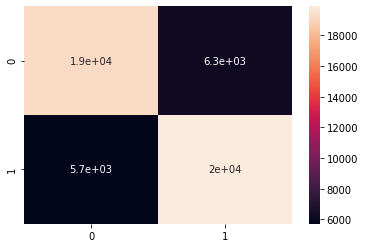

In [ ]:
# LOGISTIC REGRESSION CLASSIFIER

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

model_LG = LogisticRegression()
model_LG.fit(x_train, y_train)

y_pred = model_LG.predict(x_valid)

print("Training Accuracy: ", model_LG.score(x_train, y_train))
print('Testing Accuarcy: ', model_LG.score(x_valid, y_valid))

# making a classification report
cr = classification_report(y_valid,  y_pred)
print(cr)

# making a confusion matrix
cm = confusion_matrix(y_valid, y_pred)
sns.heatmap(cm, annot = True)

In [ ]:
from sklearn.metrics import roc_auc_score
print("auc score =\t" ,roc_auc_score(y_valid, y_pred))

auc score =	 0.7653250107255803


### RANDOM FOREST CLASSIFIER

Training Accuracy:  1.0
Testing Accuarcy:  0.9778585526958629
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98     25562
         1.0       0.98      0.98      0.98     25609

    accuracy                           0.98     51171
   macro avg       0.98      0.98      0.98     51171
weighted avg       0.98      0.98      0.98     51171



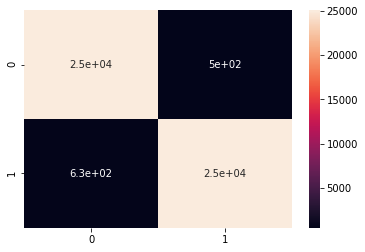

In [ ]:
# RANDOM FOREST CLASSIFIER
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

model_rf = RandomForestClassifier()
model_rf.fit(x_train, y_train)

y_predrf = model_rf.predict(x_valid)

print("Training Accuracy: ", model_rf.score(x_train, y_train))
print('Testing Accuarcy: ', model_rf.score(x_valid, y_valid))

# making a classification report
cr = classification_report(y_valid,  y_predrf)
print(cr)

# making a confusion matrix
cm = confusion_matrix(y_valid, y_predrf)
sns.heatmap(cm, annot = True)

In [ ]:
from sklearn.metrics import roc_auc_score
print("auc score =\t" ,roc_auc_score(y_valid, y_predrf))

auc score =	 0.9778609212896736


### Xg-Boost Classifier

Training Accuracy:  0.9443383182775316
Testing Accuarcy:  0.9422915323132243
              precision    recall  f1-score   support

         0.0       0.92      0.97      0.94     25562
         1.0       0.97      0.92      0.94     25609

    accuracy                           0.94     51171
   macro avg       0.94      0.94      0.94     51171
weighted avg       0.94      0.94      0.94     51171



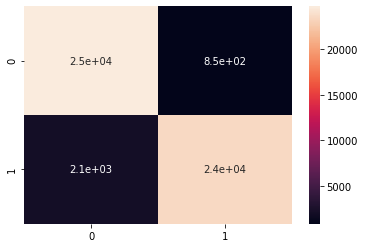

In [ ]:
# Xg-Boost Classifier

from xgboost.sklearn import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

model_xgb = XGBClassifier()
model_xgb.fit(x_train, y_train)

y_predxg = model_xgb.predict(x_valid)

print("Training Accuracy: ", model_xgb.score(x_train, y_train))
print('Testing Accuarcy: ', model_xgb.score(x_valid, y_valid))

# making a classification report
cr = classification_report(y_valid,  y_predxg)
print(cr)

# making a confusion matrix
cm = confusion_matrix(y_valid, y_predxg)
sns.heatmap(cm, annot = True)

In [ ]:
from sklearn.metrics import roc_auc_score
print("auc score =\t" ,roc_auc_score(y_valid, y_predxg))

auc score =	 0.9423139383532722


In [ ]:
# getting the avg precision score
from sklearn.metrics import average_precision_score

apc = average_precision_score(y_valid, y_predxg)
print('Average Precision Score :', apc)

Average Precision Score : 0.9269279112042733


### Xgboost(Hyperparameter tuning)

In [ ]:
from xgboost.sklearn import XGBClassifier

In [ ]:
## Hyper Parameter Optimization

params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
    
}

## Hyperparameter optimization using RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import xgboost


def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

classifier=xgboost.XGBClassifier()

random_search=RandomizedSearchCV(classifier,param_distributions=params,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=3,verbose=3)

from datetime import datetime
# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(x_train, y_train)
timer(start_time) # timing ends here for "start_time" variable

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 22.7min finished



 Time taken: 0 hours 28 minutes and 31.3 seconds.


In [ ]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.3,
              learning_rate=0.15, max_delta_step=0, max_depth=15,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
model_xgb=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.3,
              learning_rate=0.15, max_delta_step=0, max_depth=15,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
# model_xgb=xgboost.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#               colsample_bynode=1, colsample_bytree=0.5, gamma=0.2, gpu_id=-1,
#               importance_type='gain', interaction_constraints='',
#               learning_rate=0.1, max_delta_step=0, max_depth=15,
#               min_child_weight=5, monotone_constraints='()',
#               n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
#               reg_alpha=0, reg_lambda=1, scale_pos_w to

# The outcome of the program will be that you will have a solid profile in Software Development or Data Analytics with projects and you will easily be able to grab a good job/internsheight=1, subsample=1,
#               tree_method='exact', validate_parameters=1, verbosity=None)

Training Accuracy:  0.9984121788326339
Testing Accuarcy:  0.9743800199331653
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97     25562
         1.0       0.99      0.96      0.97     25609

    accuracy                           0.97     51171
   macro avg       0.97      0.97      0.97     51171
weighted avg       0.97      0.97      0.97     51171



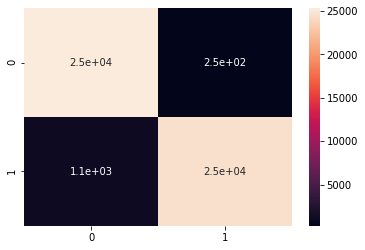

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

model_xgb.fit(x_train, y_train)

y_predxg = model_xgb.predict(x_valid)

print("Training Accuracy: ", model_xgb.score(x_train, y_train))
print('Testing Accuarcy: ', model_xgb.score(x_valid, y_valid))

# making a classification report
cr = classification_report(y_valid,  y_predxg)
print(cr)

# making a confusion matrix
cm = confusion_matrix(y_valid, y_predxg)
sns.heatmap(cm, annot = True)

In [ ]:
from sklearn.metrics import roc_auc_score
print("auc score =\t" ,roc_auc_score(y_valid, y_predxg))

auc score =	 0.9743946629955791


### ADA BOOST CLASSIFIER

Training Accuracy:  0.9158112789044522
Testing Accuarcy:  0.9120009380313068
              precision    recall  f1-score   support

         0.0       0.90      0.93      0.91     25562
         1.0       0.93      0.89      0.91     25609

    accuracy                           0.91     51171
   macro avg       0.91      0.91      0.91     51171
weighted avg       0.91      0.91      0.91     51171



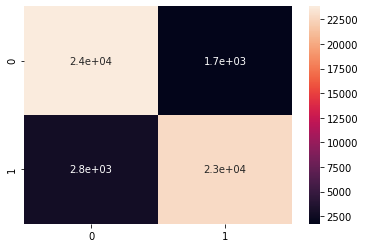

In [ ]:
# ADA BOOST CLASSIFIER

from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

model_ada = AdaBoostClassifier()
model_ada.fit(x_train, y_train)

y_predada = model_ada.predict(x_valid)

print("Training Accuracy: ", model_ada.score(x_train, y_train))
print('Testing Accuarcy: ', model_ada.score(x_valid, y_valid))

# making a classification report
cr = classification_report(y_valid,  y_predada)
print(cr)

# making a confusion matrix
cm = confusion_matrix(y_valid, y_predada)
sns.heatmap(cm, annot = True)

In [ ]:
from sklearn.metrics import roc_auc_score
print("auc score =\t" ,roc_auc_score(y_valid, y_predxg))

auc score =	 0.9423139383532722


In [ ]:
# getting the avg precision score
from sklearn.metrics import average_precision_score

apc = average_precision_score(y_valid, y_predada)
print('Average Precision Score :', apc)

Average Precision Score : 0.8830971520989217


### LGBMClassifier

Training Accuracy:  0.9668462940253953
Testing Accuarcy:  0.9652732993296984
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     25562
         1.0       0.98      0.95      0.96     25609

    accuracy                           0.97     51171
   macro avg       0.97      0.97      0.97     51171
weighted avg       0.97      0.97      0.97     51171



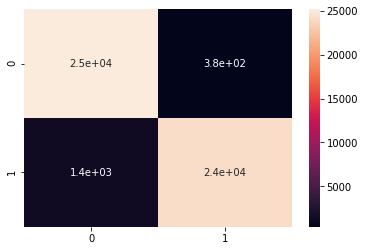

In [ ]:
# light boost classifier

from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

model_lgb = LGBMClassifier()
model_lgb.fit(x_train, y_train)

y_pred = model_lgb.predict(x_valid)

print("Training Accuracy: ", model_lgb.score(x_train, y_train))
print('Testing Accuarcy: ', model_lgb.score(x_valid, y_valid))

# making a classification report
cr = classification_report(y_valid,  y_pred)
print(cr)

# making a confusion matrix
cm = confusion_matrix(y_valid, y_pred)
sns.heatmap(cm, annot = True)

In [ ]:
from sklearn.metrics import roc_auc_score
print("auc score =\t" ,roc_auc_score(y_valid, y_pred))

auc score =	 0.9652914168969252


### GAUSSIAN NAIVE BAYES CLASSIFIER

Training Accuracy:  0.6632500012214009
Testing Accuarcy:  0.6623087295538489
              precision    recall  f1-score   support

         0.0       0.88      0.38      0.53     25562
         1.0       0.60      0.95      0.74     25609

    accuracy                           0.66     51171
   macro avg       0.74      0.66      0.63     51171
weighted avg       0.74      0.66      0.63     51171



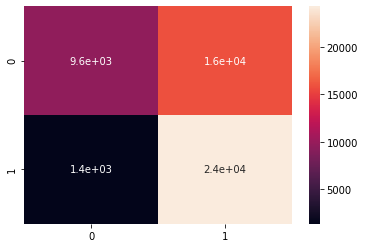

In [ ]:
# GAUSSIAN NAIVE BAYES CLASSIFIER

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

gnb = GaussianNB()
gnb.fit(x_train, y_train)
y_prednb = gnb.predict(x_valid)
  
print("Training Accuracy: ", gnb.score(x_train, y_train))
print('Testing Accuarcy: ', gnb.score(x_valid, y_valid))

# making a classification report
cr = classification_report(y_valid,  y_prednb)
print(cr)

# making a confusion matrix
cm = confusion_matrix(y_valid, y_prednb)
sns.heatmap(cm, annot = True)

# Adding Normalization after Standardizaton

In [ ]:
X.shape

(135493, 104)

In [ ]:
from imblearn.over_sampling import SMOTE

x_resample, y_resample = SMOTE().fit_sample(X, y.values.ravel()) 

# checking the shape of x_resample and y_resample
print("Shape of x:", x_resample.shape)
print("Shape of y:", y_resample.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Shape of x: (255854, 104)
Shape of y: (255854,)


In [ ]:
  # applying Normalization
  from sklearn.preprocessing import MinMaxScaler
  nor=MinMaxScaler()
  x_resample = nor.fit_transform(x_resample)
  # x_valid = nor.transform(x_valid)

In [ ]:

# train and valid sets from train
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_resample, y_resample, test_size = 0.2, random_state = 0)

# checking the shapes
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)

(204683, 104)
(204683,)
(51171, 104)
(51171,)


In [ ]:
# applying standardization

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_valid = sc.transform(x_valid)
# x_test = sc.transform(x_test)

In [ ]:
  # applying Normalization
  from sklearn.preprocessing import MinMaxScaler
  nor=MinMaxScaler()
  x_train = nor.fit_transform(x_train)
  x_valid = nor.transform(x_valid)

### LOGISTIC REGRESSION CLASSIFIER

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Training Accuracy:  0.7619001089489601
Testing Accuarcy:  0.7600398663305388
              precision    recall  f1-score   support

         0.0       0.77      0.75      0.76     25562
         1.0       0.75      0.77      0.76     25609

    accuracy                           0.76     51171
   macro avg       0.76      0.76      0.76     51171
weighted avg       0.76      0.76      0.76     51171



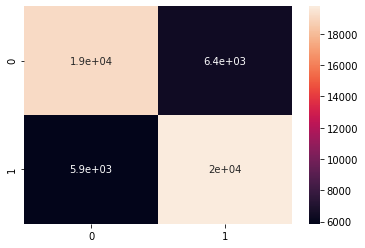

In [ ]:
# LOGISTIC REGRESSION CLASSIFIER

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

model_LG = LogisticRegression()
model_LG.fit(x_train, y_train)

y_pred = model_LG.predict(x_valid)

print("Training Accuracy: ", model_LG.score(x_train, y_train))
print('Testing Accuarcy: ', model_LG.score(x_valid, y_valid))

# making a classification report
cr = classification_report(y_valid,  y_pred)
print(cr)

# making a confusion matrix
cm = confusion_matrix(y_valid, y_pred)
sns.heatmap(cm, annot = True)

In [ ]:
from sklearn.metrics import roc_auc_score
print("auc score =\t" ,roc_auc_score(y_valid, y_pred))

auc score =	 0.7600293788771453


### RANDOM FOREST CLASSIFIER

Training Accuracy:  1.0
Testing Accuarcy:  0.9765687596490199
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98     25562
         1.0       0.98      0.97      0.98     25609

    accuracy                           0.98     51171
   macro avg       0.98      0.98      0.98     51171
weighted avg       0.98      0.98      0.98     51171



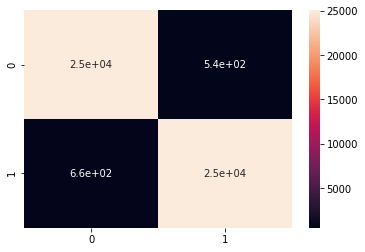

In [ ]:
# RANDOM FOREST CLASSIFIER
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

model_rf = RandomForestClassifier()
model_rf.fit(x_train, y_train)

y_predrf = model_rf.predict(x_valid)

print("Training Accuracy: ", model_rf.score(x_train, y_train))
print('Testing Accuarcy: ', model_rf.score(x_valid, y_valid))

# making a classification report
cr = classification_report(y_valid,  y_predrf)
print(cr)

# making a confusion matrix
cm = confusion_matrix(y_valid, y_predrf)
sns.heatmap(cm, annot = True)

In [ ]:
from sklearn.metrics import roc_auc_score
print("auc score =\t" ,roc_auc_score(y_valid, y_predrf))

auc score =	 0.9765709476605335


Training Accuracy:  0.9436689905854418
Testing Accuarcy:  0.9421547360809833
              precision    recall  f1-score   support

         0.0       0.92      0.97      0.94     25562
         1.0       0.96      0.92      0.94     25609

    accuracy                           0.94     51171
   macro avg       0.94      0.94      0.94     51171
weighted avg       0.94      0.94      0.94     51171



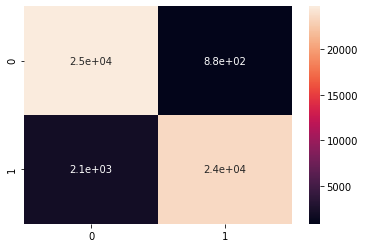

In [ ]:
# Xg-Boost Classifier

from xgboost.sklearn import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

model_xgb = XGBClassifier()
model_xgb.fit(x_train, y_train)

y_predxg = model_xgb.predict(x_valid)

print("Training Accuracy: ", model_xgb.score(x_train, y_train))
print('Testing Accuarcy: ', model_xgb.score(x_valid, y_valid))

# making a classification report
cr = classification_report(y_valid,  y_predxg)
print(cr)

# making a confusion matrix
cm = confusion_matrix(y_valid, y_predxg)
sns.heatmap(cm, annot = True)

In [ ]:
from sklearn.metrics import roc_auc_score
print("auc score =\t" ,roc_auc_score(y_valid, y_predxg))

auc score =	 0.9421762983828942


In [ ]:
# getting the avg precision score
from sklearn.metrics import average_precision_score

apc = average_precision_score(y_valid, y_predxg)
print('Average Precision Score :', apc)

Average Precision Score : 0.9263361818431204


In [ ]:
# # plotting an AUC ROC Curve

# from sklearn.metrics import precision_recall_curve
# from sklearn.utils.fixes import signature

# precision, recall, _ = precision_recall_curve(y_valid, y_pred)

# step_kwargs = ({'step':'post'} if 'step' in signature(plt.fill_between).parameters else{})

# plt.step(recall, precision, color = 'pink', alpha = 0.6, where = 'post')
# plt.fill_between(recall, precision, color = 'pink', alpha = 0.6, **step_kwargs)

# plt.title('Precision Recall Curve')
# plt.xlabel('Recall', fontsize = 15)
# plt.ylabel('Precision', fontsize =15)
# plt.ylim([0.0, 1.05])
# plt.xlim([0.0, 1.0])

Training Accuracy:  0.9124890684619631
Testing Accuarcy:  0.9116100916534756
              precision    recall  f1-score   support

         0.0       0.90      0.92      0.91     25562
         1.0       0.92      0.90      0.91     25609

    accuracy                           0.91     51171
   macro avg       0.91      0.91      0.91     51171
weighted avg       0.91      0.91      0.91     51171



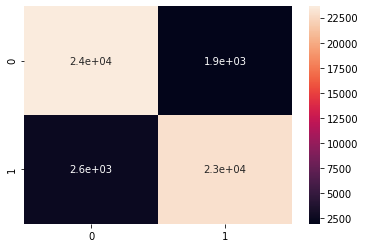

In [ ]:
# ADA BOOST CLASSIFIER

from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

model_ada = AdaBoostClassifier()
model_ada.fit(x_train, y_train)

y_predada = model_ada.predict(x_valid)

print("Training Accuracy: ", model_ada.score(x_train, y_train))
print('Testing Accuarcy: ', model_ada.score(x_valid, y_valid))

# making a classification report
cr = classification_report(y_valid,  y_predada)
print(cr)

# making a confusion matrix
cm = confusion_matrix(y_valid, y_predada)
sns.heatmap(cm, annot = True)

In [ ]:
# from sklearn.metrics import roc_auc_score
# print("auc score =\t" ,roc_auc_score(y_valid, y_predxg))

In [ ]:
# getting the avg precision score
from sklearn.metrics import average_precision_score

apc = average_precision_score(y_valid, y_predada)
print('Average Precision Score :', apc)

Average Precision Score : 0.879816532583574


Training Accuracy:  0.9668951500613143
Testing Accuarcy:  0.9655078071563972
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     25562
         1.0       0.99      0.95      0.96     25609

    accuracy                           0.97     51171
   macro avg       0.97      0.97      0.97     51171
weighted avg       0.97      0.97      0.97     51171



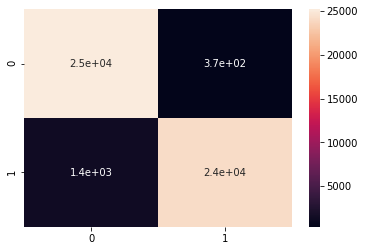

In [ ]:
# light boost classifier

from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

model_lgb = LGBMClassifier()
model_lgb.fit(x_train, y_train)

y_pred = model_lgb.predict(x_valid)

print("Training Accuracy: ", model_lgb.score(x_train, y_train))
print('Testing Accuarcy: ', model_lgb.score(x_valid, y_valid))

# making a classification report
cr = classification_report(y_valid,  y_pred)
print(cr)

# making a confusion matrix
cm = confusion_matrix(y_valid, y_pred)
sns.heatmap(cm, annot = True)

### GAUSSIAN NAIVE BAYES CLASSIFIER

In [ ]:
from sklearn.metrics import roc_auc_score
print("auc score =\t" ,roc_auc_score(y_valid, y_pred))

auc score =	 0.9655263198086965


Training Accuracy:  0.6640365833996961
Testing Accuarcy:  0.6613902405659455
              precision    recall  f1-score   support

         0.0       0.87      0.38      0.53     25562
         1.0       0.60      0.94      0.74     25609

    accuracy                           0.66     51171
   macro avg       0.74      0.66      0.63     51171
weighted avg       0.74      0.66      0.63     51171



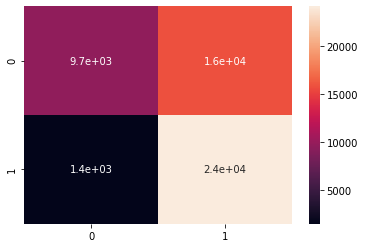

In [ ]:
# GAUSSIAN NAIVE BAYES CLASSIFIER

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

gnb = GaussianNB()
gnb.fit(x_train, y_train)
y_prednb = gnb.predict(x_valid)
  
print("Training Accuracy: ", gnb.score(x_train, y_train))
print('Testing Accuarcy: ', gnb.score(x_valid, y_valid))

# making a classification report
cr = classification_report(y_valid,  y_prednb)
print(cr)

# making a confusion matrix
cm = confusion_matrix(y_valid, y_prednb)
sns.heatmap(cm, annot = True)

# Feature selection using mutual_info_classif,f_classif

In [ ]:
X.shape

(135493, 104)

In [ ]:
features=X.columns
features

Index(['disrict', 'client_catg', 'region', 'region_group', 'coop_time',
       'is_weekday_mean', 'transactions_count', 'tarif_type_mean',
       'tarif_type_std', 'tarif_type_min',
       ...
       'months_number_range', 'months_number_max_mean', 'counter_type_range',
       'counter_type_max_mean', 'invoice_month_range',
       'invoice_month_max_mean', 'invoice_year_range', 'invoice_year_max_mean',
       'delta_index_range', 'delta_index_max_mean'],
      dtype='object', length=104)

In [ ]:
  # applying SMOTE
  from imblearn.over_sampling import SMOTE

  x_new, y_new = SMOTE().fit_sample(X, y.values.ravel()) 

  # checking the shape of x_resample and y_resample
  print("Shape of x:", x_new.shape)
  print("Shape of y:", y_new.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Shape of x: (255854, 104)
Shape of y: (255854,)


In [ ]:
  # applying standardization

  from sklearn.preprocessing import StandardScaler

  sc = StandardScaler()
  x_new = sc.fit_transform(x_new)
  # x_valid = sc.transform(x_valid)
  
#   # applying Normalization
#   from sklearn.preprocessing import MinMaxScaler
#   nor=MinMaxScaler()
#   x_resample = nor.fit_transform(x_resample)
#   # x_valid = nor.transform(x_valid)

In [ ]:
# df = pd.DataFrame(my_array, columns = ['Column_A','Column_B','Column_C'])
x_new=pd.DataFrame(x_new)

In [ ]:
x_new.shape

(255854, 104)

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif 

In [ ]:
# test_acc=[]
# ypoints2=[]
# for i in range(70,96):
#   x_resample = SelectKBest(mutual_info_classif, k=i).fit_transform(x_resample, y_resample) 
#   # X_new.shape





#   # train and valid sets from train
#   from sklearn.model_selection import train_test_split

#   x_train, x_valid, y_train, y_valid = train_test_split(x_resample, y_resample, test_size = 0.2, random_state = 0)

#   # checking the shapes
#   print(x_train.shape)
#   # print(y_train.shape)
#   # print(x_valid.shape)
#   # print(y_valid.shape)



#   # LOGISTIC REGRESSION CLASSIFIER

#   from sklearn.linear_model import LogisticRegression
#   # from sklearn.metrics import confusion_matrix
#   # from sklearn.metrics import classification_report

#   model_LG = LogisticRegression()
#   model_LG.fit(x_train, y_train)

#   y_pred = model_LG.predict(x_valid)

#   # print("Training Accuracy: ", model_LG.score(x_train, y_train))
#   test_acc.append(model_LG.score(x_valid, y_valid))

  


#   from sklearn.metrics import roc_auc_score
#   ypoints2.append(roc_auc_score(y_valid, y_pred))

### RANDOM FOREST

In [ ]:
# RANDOM FOREST CLASSIFIER
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
test_acc_rf=[]
ypointsrf=[]
for i in range(80,105):
    x_resample = SelectKBest(f_classif, k=i).fit_transform(x_new, y_new) 
    
    # train and valid sets from train
    from sklearn.model_selection import train_test_split
    x_train, x_valid, y_train, y_valid = train_test_split(x_resample, y_new, test_size = 0.2, random_state = 0)

    # checking the shapes
    print(x_train.shape)
    # print(y_train.shape)
    # print(x_valid.shape)
    # print(y_valid.shape)



    model_rf = RandomForestClassifier()
    model_rf.fit(x_train, y_train)

    y_predrf = model_rf.predict(x_valid)

    print("Training Accuracy: ", model_rf.score(x_train, y_train))
    print('Testing Accuarcy: ', model_rf.score(x_valid, y_valid))

    # making a classification report
    cr = classification_report(y_valid,  y_predrf)
    print(cr)

    # making a confusion matrix
    # cm = confusion_matrix(y_valid, y_predrf)
    # sns.heatmap(cm, annot = True)



    

    from sklearn.metrics import roc_auc_score
    ypointsrf.append(roc_auc_score(y_valid, y_predrf))

(204683, 80)
Training Accuracy:  1.0
Testing Accuarcy:  0.9769791483457427
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98     25562
         1.0       0.98      0.97      0.98     25609

    accuracy                           0.98     51171
   macro avg       0.98      0.98      0.98     51171
weighted avg       0.98      0.98      0.98     51171

(204683, 81)
Training Accuracy:  1.0
Testing Accuarcy:  0.9768032674757187
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98     25562
         1.0       0.98      0.97      0.98     25609

    accuracy                           0.98     51171
   macro avg       0.98      0.98      0.98     51171
weighted avg       0.98      0.98      0.98     51171

(204683, 82)
Training Accuracy:  1.0
Testing Accuarcy:  0.9768814367512849
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98     25562
         1.0

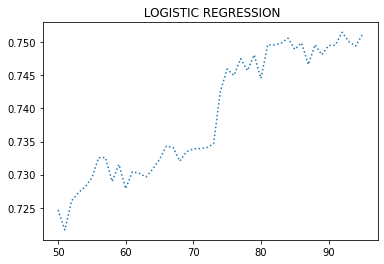

In [ ]:
xpoints=list(range(50,96))
plt.title(" LOGISTIC REGRESSION")
plt.plot(xpoints,ypoints, linestyle = 'dotted')
plt.show()  

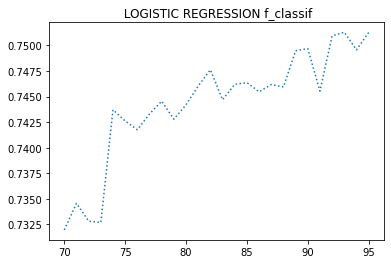

In [ ]:
xpoints=list(range(70,96))
plt.title(" LOGISTIC REGRESSION f_classif")
plt.plot(xpoints,ypoints2, linestyle = 'dotted')
plt.show()  

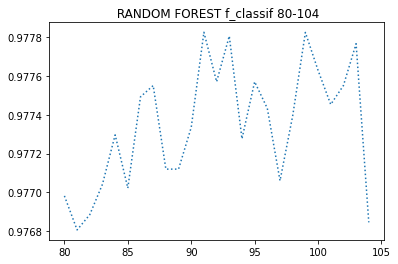

In [ ]:
xpoints=list(range(80,105))
plt.title(" RANDOM FOREST f_classif 80-104")
plt.plot(xpoints,ypointsrf, linestyle = 'dotted')
plt.show()  

In [ ]:
# applying SMOTE

from imblearn.over_sampling import SMOTE

x_resample, y_resample = SMOTE().fit_sample(X_new, y.values.ravel()) 

# checking the shape of x_resample and y_resample
print("Shape of x:", x_resample.shape)
print("Shape of y:", y_resample.shape)




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Shape of x: (255854, 30)
Shape of y: (255854,)


In [ ]:

# train and valid sets from train
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_resample, y_resample, test_size = 0.2, random_state = 0)

# checking the shapes
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)

(204683, 30)
(204683,)
(51171, 30)
(51171,)


In [ ]:
# applying standardization

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_valid = sc.transform(x_valid)
# x_test = sc.transform(x_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Training Accuracy:  0.7072350903592385
Testing Accuarcy:  0.7080572980789901
              precision    recall  f1-score   support

         0.0       0.71      0.69      0.70     25562
         1.0       0.70      0.72      0.71     25609

    accuracy                           0.71     51171
   macro avg       0.71      0.71      0.71     51171
weighted avg       0.71      0.71      0.71     51171



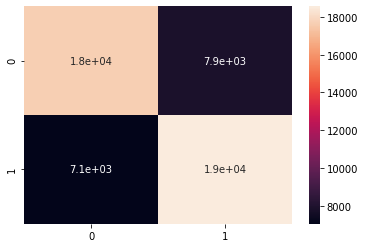

In [ ]:
# LOGISTIC REGRESSION CLASSIFIER

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

model_LG = LogisticRegression()
model_LG.fit(x_train, y_train)

y_pred = model_LG.predict(x_valid)

print("Training Accuracy: ", model_LG.score(x_train, y_train))
print('Testing Accuarcy: ', model_LG.score(x_valid, y_valid))

# making a classification report
cr = classification_report(y_valid,  y_pred)
print(cr)

# making a confusion matrix
cm = confusion_matrix(y_valid, y_pred)
sns.heatmap(cm, annot = True)

In [ ]:
from sklearn.metrics import roc_auc_score
print("auc score =\t" ,roc_auc_score(y_valid, y_pred))

auc score =	 0.7080420640239216


In [ ]:
# RANDOM FOREST CLASSIFIER
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

model_rf = RandomForestClassifier()
model_rf.fit(x_train, y_train)

y_predrf = model_rf.predict(x_valid)

print("Training Accuracy: ", model_rf.score(x_train, y_train))
print('Testing Accuarcy: ', model_rf.score(x_valid, y_valid))

# making a classification report
cr = classification_report(y_valid,  y_predrf)
print(cr)

# making a confusion matrix
cm = confusion_matrix(y_valid, y_predrf)
sns.heatmap(cm, annot = True)

KeyboardInterrupt: ignored

In [ ]:
from sklearn.metrics import roc_auc_score
print("auc score =\t" ,roc_auc_score(y_valid, y_predrf))

auc score =	 0.961628505522841


Training Accuracy:  0.8007748567296746
Testing Accuarcy:  0.7984796075902366
              precision    recall  f1-score   support

         0.0       0.79      0.81      0.80     25562
         1.0       0.80      0.79      0.80     25609

    accuracy                           0.80     51171
   macro avg       0.80      0.80      0.80     51171
weighted avg       0.80      0.80      0.80     51171



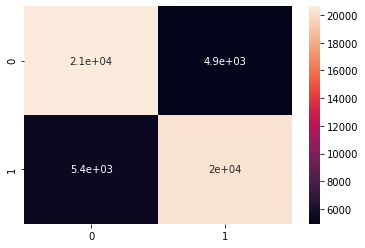

In [ ]:
# Xg-Boost Classifier

from xgboost.sklearn import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

model_xgb = XGBClassifier()
model_xgb.fit(x_train, y_train)

y_predxg = model_xgb.predict(x_valid)

print("Training Accuracy: ", model_xgb.score(x_train, y_train))
print('Testing Accuarcy: ', model_xgb.score(x_valid, y_valid))

# making a classification report
cr = classification_report(y_valid,  y_predxg)
print(cr)

# making a confusion matrix
cm = confusion_matrix(y_valid, y_predxg)
sns.heatmap(cm, annot = True)

In [ ]:
from sklearn.metrics import roc_auc_score
print("auc score =\t" ,roc_auc_score(y_valid, y_predxg))

auc score =	 0.7984875148219817


In [ ]:
# getting the avg precision score
from sklearn.metrics import average_precision_score

apc = average_precision_score(y_valid, y_predxg)
print('Average Precision Score :', apc)

Average Precision Score : 0.9364376863690973


In [ ]:
# # plotting an AUC ROC Curve

# from sklearn.metrics import precision_recall_curve
# from sklearn.utils.fixes import signature

# precision, recall, _ = precision_recall_curve(y_valid, y_pred)

# step_kwargs = ({'step':'post'} if 'step' in signature(plt.fill_between).parameters else{})

# plt.step(recall, precision, color = 'pink', alpha = 0.6, where = 'post')
# plt.fill_between(recall, precision, color = 'pink', alpha = 0.6, **step_kwargs)

# plt.title('Precision Recall Curve')
# plt.xlabel('Recall', fontsize = 15)
# plt.ylabel('Precision', fontsize =15)
# plt.ylim([0.0, 1.05])
# plt.xlim([0.0, 1.0])

Training Accuracy:  0.9187133274380384
Testing Accuarcy:  0.9179613452932325
              precision    recall  f1-score   support

         0.0       0.90      0.94      0.92     25562
         1.0       0.93      0.90      0.92     25609

    accuracy                           0.92     51171
   macro avg       0.92      0.92      0.92     51171
weighted avg       0.92      0.92      0.92     51171



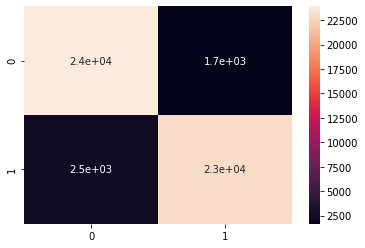

In [ ]:
# ADA BOOST CLASSIFIER

from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

model_ada = AdaBoostClassifier()
model_ada.fit(x_train, y_train)

y_predada = model_ada.predict(x_valid)

print("Training Accuracy: ", model_ada.score(x_train, y_train))
print('Testing Accuarcy: ', model_ada.score(x_valid, y_valid))

# making a classification report
cr = classification_report(y_valid,  y_predada)
print(cr)

# making a confusion matrix
cm = confusion_matrix(y_valid, y_predada)
sns.heatmap(cm, annot = True)

In [ ]:
from sklearn.metrics import roc_auc_score
print("auc score =\t" ,roc_auc_score(y_valid, y_predxg))

auc score =	 0.9485296215639949


In [ ]:
# getting the avg precision score
from sklearn.metrics import average_precision_score

apc = average_precision_score(y_valid, y_predada)
print('Average Precision Score :', apc)

Average Precision Score : 0.8900665556079694


Training Accuracy:  0.9685611408861508
Testing Accuarcy:  0.9667976002032401
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     25562
         1.0       0.99      0.94      0.97     25609

    accuracy                           0.97     51171
   macro avg       0.97      0.97      0.97     51171
weighted avg       0.97      0.97      0.97     51171



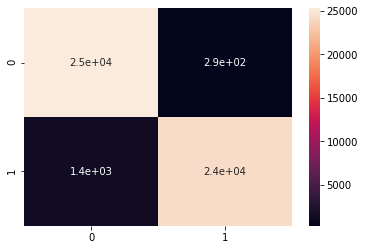

In [ ]:
# light boost classifier

from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

model_lgb = LGBMClassifier()
model_lgb.fit(x_train, y_train)

y_pred = model_lgb.predict(x_valid)

print("Training Accuracy: ", model_lgb.score(x_train, y_train))
print('Testing Accuarcy: ', model_lgb.score(x_valid, y_valid))

# making a classification report
cr = classification_report(y_valid,  y_pred)
print(cr)

# making a confusion matrix
cm = confusion_matrix(y_valid, y_pred)
sns.heatmap(cm, annot = True)

In [ ]:
from sklearn.metrics import roc_auc_score
print("auc score =\t" ,roc_auc_score(y_valid, y_pred))

auc score =	 0.9668176575937447


Training Accuracy:  0.6783611731311345
Testing Accuarcy:  0.6750503214711457
              precision    recall  f1-score   support

         0.0       0.84      0.43      0.57     25562
         1.0       0.62      0.92      0.74     25609

    accuracy                           0.68     51171
   macro avg       0.73      0.67      0.65     51171
weighted avg       0.73      0.68      0.65     51171



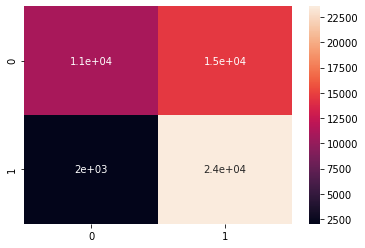

In [ ]:
# GAUSSIAN NAIVE BAYES CLASSIFIER

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

gnb = GaussianNB()
gnb.fit(x_train, y_train)
y_prednb = gnb.predict(x_valid)
  
print("Training Accuracy: ", gnb.score(x_train, y_train))
print('Testing Accuarcy: ', gnb.score(x_valid, y_valid))

# making a classification report
cr = classification_report(y_valid,  y_prednb)
print(cr)

# making a confusion matrix
cm = confusion_matrix(y_valid, y_prednb)
sns.heatmap(cm, annot = True)